## Import of Libraries

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##  Data Collection&Visualization

In [3]:
from google.colab import drive
import zipfile
import os

# file ID of ASL dataset (If this id does not work loading your own dataset on your google drive storage and insert its id below)
file_id = '1Uqrh2JtnaUWg8Uthxj98Yn8wHZY6coFs'

# Download the file
!gdown --id $file_id -O /content/dataset.zip

# Path of the file zip
zip_path = '/content/dataset.zip'

# extraction path
extract_path = '/content/dataset'

# Creation of the directory
os.makedirs(extract_path, exist_ok=True)

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Successfull Extraction!')


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Uqrh2JtnaUWg8Uthxj98Yn8wHZY6coFs
From (redirected): https://drive.google.com/uc?id=1Uqrh2JtnaUWg8Uthxj98Yn8wHZY6coFs&confirm=t&uuid=3a2e3a11-7785-4516-be01-5e122404a309
To: /content/dataset.zip
100% 7.07G/7.07G [02:46<00:00, 42.3MB/s]
Successfull Extraction!


<ipython-input-4-2ea6dd588862>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(sorted_classes))


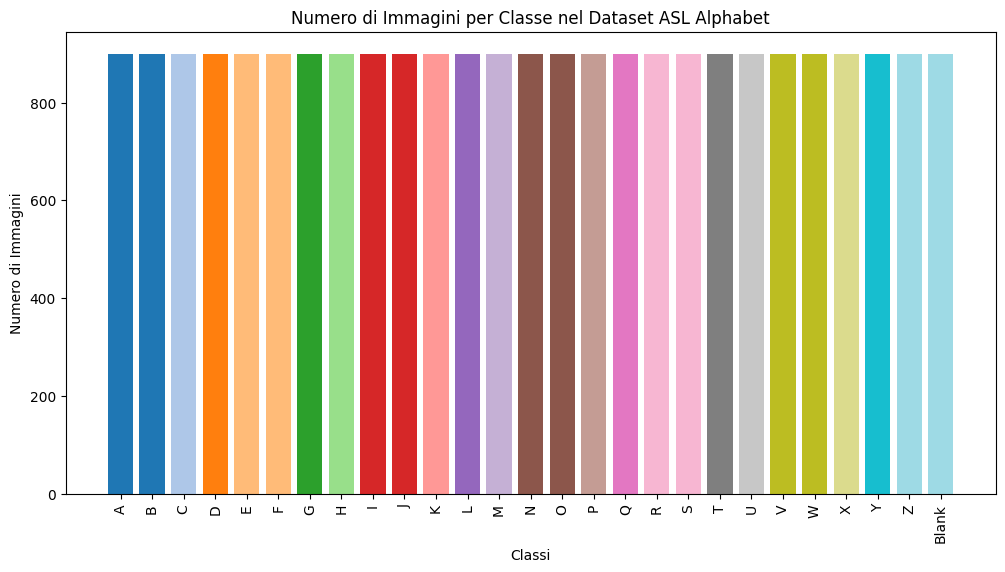

In [4]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(dataset_path):
    #Class List
    class_names = os.listdir(dataset_path)

    #Special Class
    special_class = 'Blank'


    regular_classes = [cls for cls in class_names if cls != special_class]

    # Class sorting
    regular_classes.sort()


    sorted_classes = regular_classes + [special_class]

    # Image counts list
    image_counts = []

    #Counting the number of images for each folder
    for class_name in sorted_classes:
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            image_count = len(os.listdir(class_folder))
            image_counts.append(image_count)

    # color list
    colors = plt.cm.get_cmap('tab20', len(sorted_classes))

    # Histogram creation
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_classes, image_counts, color=[colors(i) for i in range(len(sorted_classes))])
    plt.xlabel('Classi')
    plt.ylabel('Numero di Immagini')
    plt.title('Numero di Immagini per Classe nel Dataset ASL Alphabet')
    plt.xticks(rotation=90)
    plt.show()

# Train Histogram
dataset_path = '/content/dataset/Train_Alphabet'
plot_class_distribution(dataset_path)


<ipython-input-4-2ea6dd588862>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(sorted_classes))


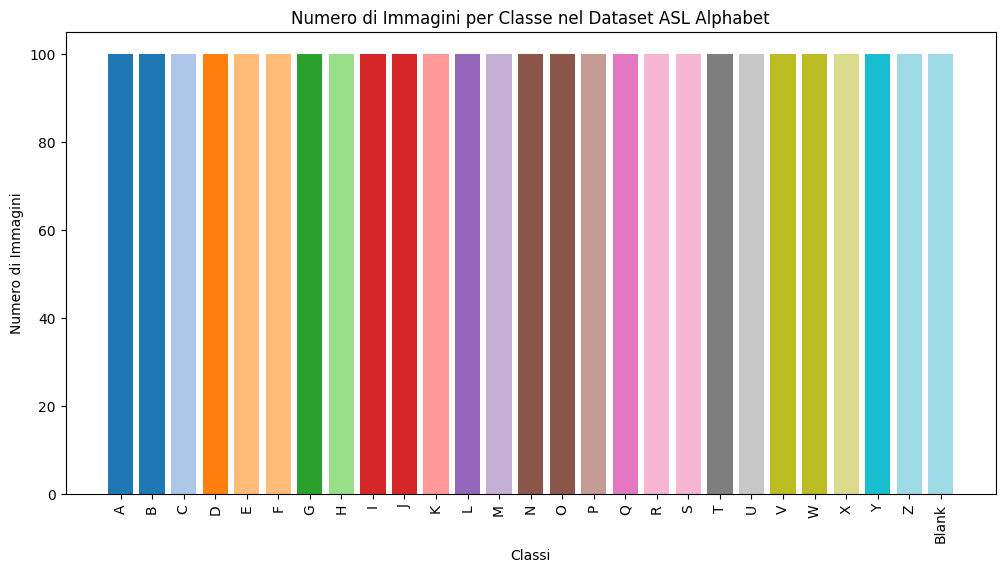

In [5]:
# Test Histogram
dataset_path = '/content/dataset/Test_Alphabet'
plot_class_distribution(dataset_path)

Immagini per la lettera A!


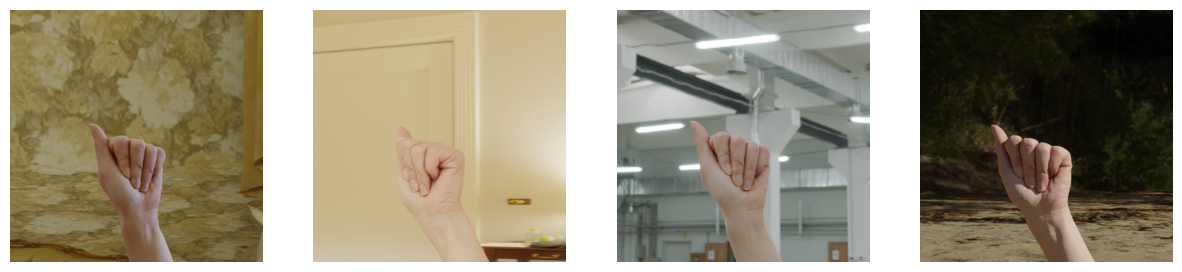

In [6]:
# Example Path
dataset_path = '/content/dataset/Train_Alphabet/A'

# Collecting all images in folder A
image_files = os.listdir(dataset_path)
image_files = [os.path.join(dataset_path, img) for img in image_files]

#Selecting 4 random images
random_images = random.sample(image_files, 4)

#subplot
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

print("Immagini per la lettera A!")
#Showing the images
for i, img_path in enumerate(random_images):
    ax = axes[i]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

## Data Preparation

In [7]:
import os
import shutil
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Path al dataset
dataset_path = '/content/dataset/Train_Alphabet'

# Creare liste per immagini e labels
images = []
labels = []

# Leggere le immagini e le etichette dalle cartelle
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            images.append(os.path.join(label_path, image_file))
            labels.append(label)

# Convertire le liste in array numpy
images = np.array(images)
labels = np.array(labels)

# Definire la dimensione dei set
train_size = 0.8
val_size = 0.2

# Stratified split per train e test
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size , train_size=train_size, random_state=42)
for train_index, val_index in strat_split.split(images, labels):
    train_images = images[train_index]
    train_labels = labels[train_index]
    val_images = images[val_index]
    val_labels = labels[val_index]



# Funzione per creare le directory e copiare i file
def create_split_directory(images, labels, split_name):
    split_path = os.path.join(dataset_path, '..', split_name)
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    for label in np.unique(labels):
        label_dir = os.path.join(split_path, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
    for img, lbl in zip(images, labels):
        shutil.copy(img, os.path.join(split_path, lbl, os.path.basename(img)))

# Creare le directory per train, test e validation e copiare i file
create_split_directory(train_images, train_labels, 'train')
create_split_directory(val_images, val_labels, 'val')


<ipython-input-4-2ea6dd588862>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(sorted_classes))


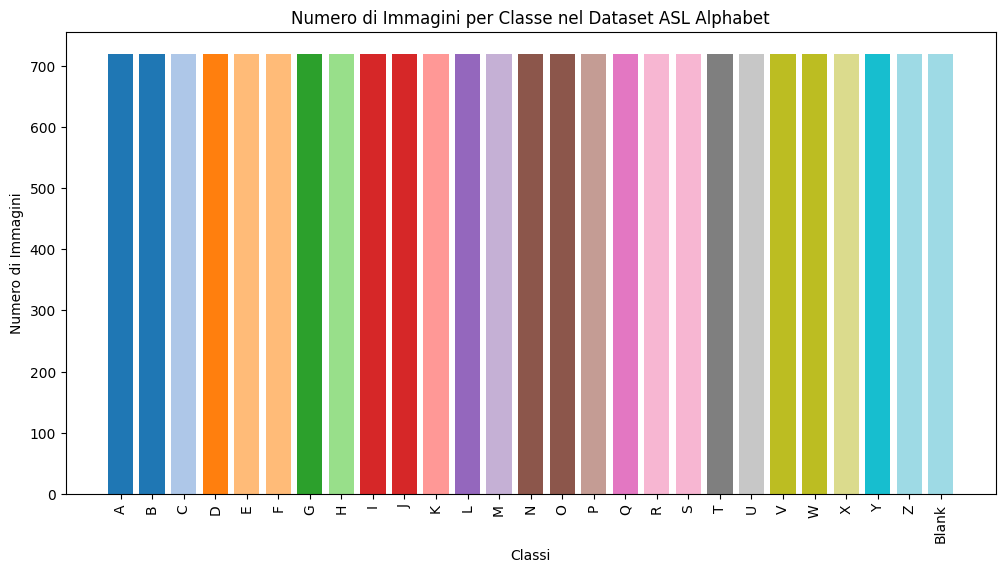

In [8]:
dataset_path = '/content/dataset/train'
plot_class_distribution(dataset_path)

<ipython-input-4-2ea6dd588862>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(sorted_classes))


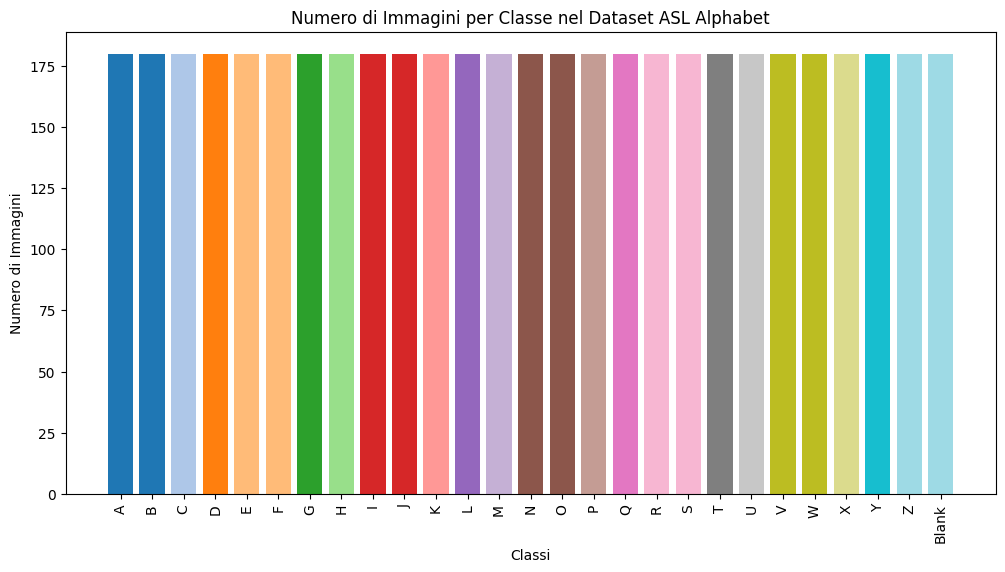

In [9]:
dataset_path = '/content/dataset/val'
plot_class_distribution(dataset_path)

## TRAINING, VALIDATION AND TESTING FUNCTIONS

In [10]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model, dataloader, loss_fn):
    model.eval()
    val_loss, val_acc = 0, 0

    # Turn on inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc


from tqdm.auto import tqdm

def training(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs):

  # Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "val_loss":[],
             "val_acc": []}

  # Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    val_loss, val_acc = val_step(model = model,
                                     dataloader = val_dataloader,
                                     loss_fn = loss_fn)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  val loss: {val_loss:.4f} - val acc: {(val_acc*100):.2f}%')

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

  return results

In [11]:
import matplotlib.pyplot as plt

def plot_train_val_loss(num_epochs, train_loss, val_loss):
    epochs = list(range(1, num_epochs + 1))  # epoch list generation

    # graph creation
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')

    # title and label
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)

    #showing the graph
    plt.show()

In [12]:
import matplotlib.pyplot as plt

def plot_train_val_acc(num_epochs, train_loss, val_loss):
    epochs = list(range(1, num_epochs + 1))  # epoch list generation

    # graph creation
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Train Acc')
    plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Acc')

    # title and label
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.legend()
    plt.grid(True)

    #showing the graph
    plt.show()

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to create confusion matrix and  calculate accuracy on test set
def calculate_accuracy_and_confusion_matrix(dataloader, model_path, class_names):
    # Loading the model
    model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = correct / total

    #confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(len(class_names)))

    #Showing the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy




In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


def show_predictions(model_path, dataloader, classes, num_images=4):
    # Load the model
    model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()  # Set the model to evaluation mode
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Make predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Plot the images with predicted and actual labels
    images = images[:num_images]
    labels = labels[:num_images]
    predicted = predicted[:num_images]

    # Function to show images with true label and predictions
    def imshow(img, title, ax):
        img = img / 2 + 0.5  # de-normalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')

    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))  #subplot

    #Showing a fixed number of images with predicted label and ture label
    for i in range(num_images):
        imshow(images[i], f'Predicted: {classes[predicted[i]]}\nActual: {classes[labels[i]]}', axs[i])

    plt.tight_layout()
    plt.show()




## 3-layer CNN


### Data Pre-processing

In [ ]:
#transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Loading the dataset
train = datasets.ImageFolder(root='/content/dataset/train', transform=transform)
val = datasets.ImageFolder(root='/content/dataset/val', transform=transform)
test = datasets.ImageFolder(root='/content/dataset/Test_Alphabet', transform=transform)

In [ ]:
#class names
class_names = train.classes
num_classes = len(class_names)
print(class_names)
print(num_classes)

['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
27


In [ ]:
#number of samples
train_samples = len(train)
val_samples = len(val)
test_samples= len(test)
print(f'Number of training images: {train_samples}')
print(f'Number of images in the validation set: {val_samples}')
print(f'Number of images in the validation set: {test_samples}')

Number of training images: 19440
Number of images in the validation set: 4860
Number of images in the validation set: 2700


In [ ]:
# Creating DataLoaders
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


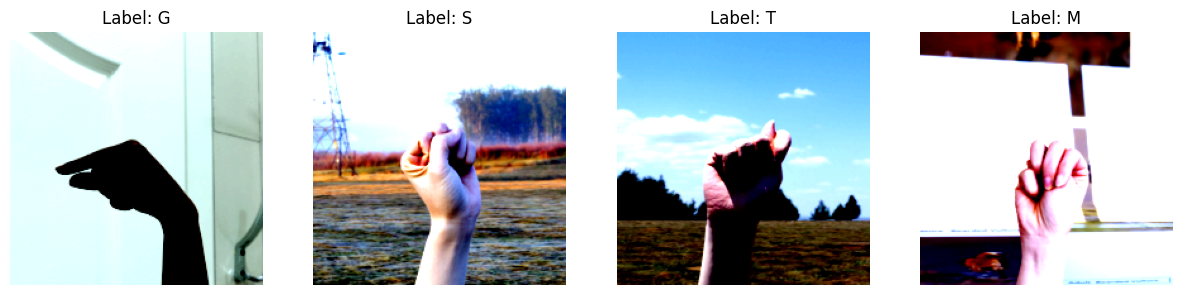

In [ ]:
num_images_to_plot = 4
# Batch of images extracted
data_iter = iter(train_loader)
images, labels = next(data_iter)

#subplot
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

# loop to plot a fixed number of images and their labels
for i in range(num_images_to_plot):
    ax = axes[i]
    image = np.transpose(images[i].numpy(), (1, 2, 0))
    label = labels[i].item()
    ax.imshow(image)
    ax.set_title(f'Label: {class_names[label]}')
    ax.axis('off')

#plot
plt.show()

### CNN without DROPOUT



#### Definition 3-layer CNN without DROPOUT

In [ ]:
class exampleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(exampleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 23 * 23, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 23 * 23)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate and move the model to the GPU
examplecnn_model = exampleCNN(num_classes=num_classes).to(device)


In [ ]:
summary(examplecnn_model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Conv2d-3           [-1, 64, 97, 97]          18,496
         MaxPool2d-4           [-1, 64, 48, 48]               0
            Conv2d-5          [-1, 128, 46, 46]          73,856
         MaxPool2d-6          [-1, 128, 23, 23]               0
            Linear-7                  [-1, 512]      34,669,056
            Linear-8                   [-1, 27]          13,851
Total params: 34,776,155
Trainable params: 34,776,155
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 20.27
Params size (MB): 132.66
Estimated Total Size (MB): 153.39
----------------------------------------------------------------


#### Full Training and Validation

In [ ]:
# Define loss function and optimizer
examplecnn_criterion = nn.CrossEntropyLoss()
examplecnn_optimizer = optim.Adam(examplecnn_model.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results_cnn = training(model = examplecnn_model,
                      train_dataloader = train_loader,
                      val_dataloader = val_loader,
                      optimizer =  examplecnn_optimizer,
                      loss_fn = examplecnn_criterion,
                      epochs = 8)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4250 - Train acc: 60.97% -  val loss: 0.5368 - val acc: 86.39%
Epoch: 1 | Train loss: 0.2855 - Train acc: 92.56% -  val loss: 0.2530 - val acc: 93.10%
Epoch: 2 | Train loss: 0.1018 - Train acc: 97.39% -  val loss: 0.2113 - val acc: 94.00%
Epoch: 3 | Train loss: 0.0511 - Train acc: 98.79% -  val loss: 0.1707 - val acc: 94.98%
Epoch: 4 | Train loss: 0.0244 - Train acc: 99.51% -  val loss: 0.2003 - val acc: 94.55%
Epoch: 5 | Train loss: 0.0182 - Train acc: 99.58% -  val loss: 0.1803 - val acc: 95.43%
Epoch: 6 | Train loss: 0.0171 - Train acc: 99.64% -  val loss: 0.2248 - val acc: 94.63%
Epoch: 7 | Train loss: 0.0162 - Train acc: 99.59% -  val loss: 0.1769 - val acc: 95.31%
Total Train Time: 2371.032 seconds


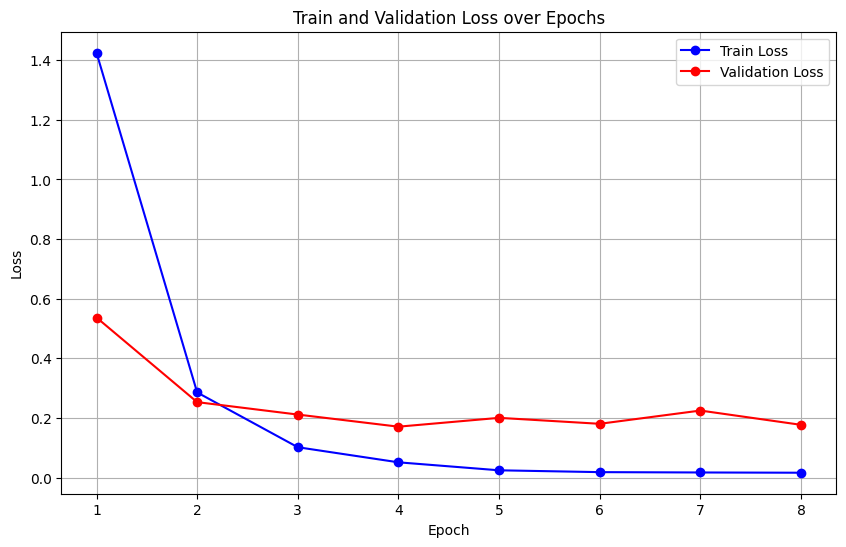

In [ ]:
plot_train_val_loss(8,  model_results_cnn ["train_loss"], model_results_cnn ["val_loss"])

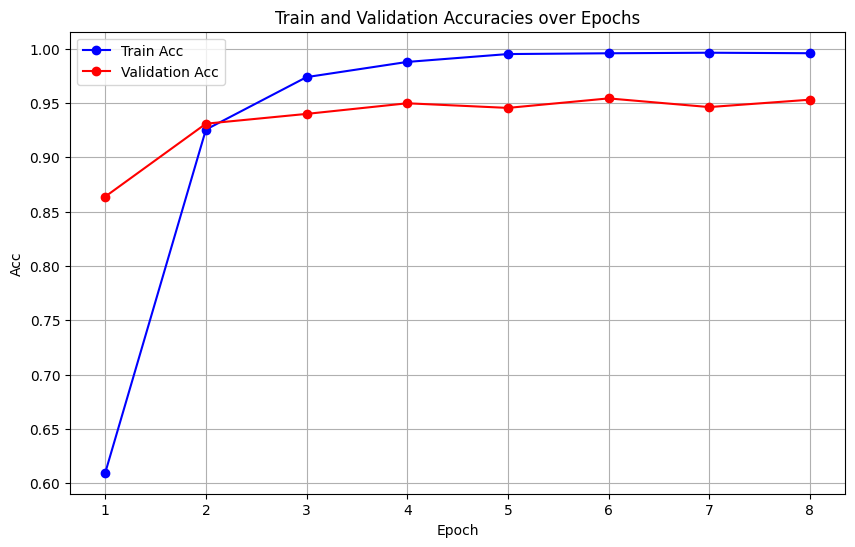

In [ ]:
plot_train_val_acc(8,  model_results_cnn ["train_acc"], model_results_cnn ["val_acc"])

In [ ]:
torch.save(examplecnn_model, 'examplecnn_model_1.pth')

#### Testing

In [ ]:
model_path='/content/examplecnn_model_1.pth'

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


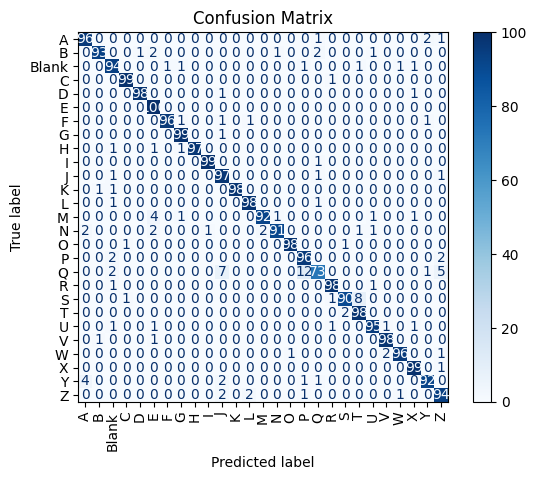

Accuracy: 95.33%


In [ ]:
accuracy = calculate_accuracy_and_confusion_matrix(test_loader, model_path, class_names)
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


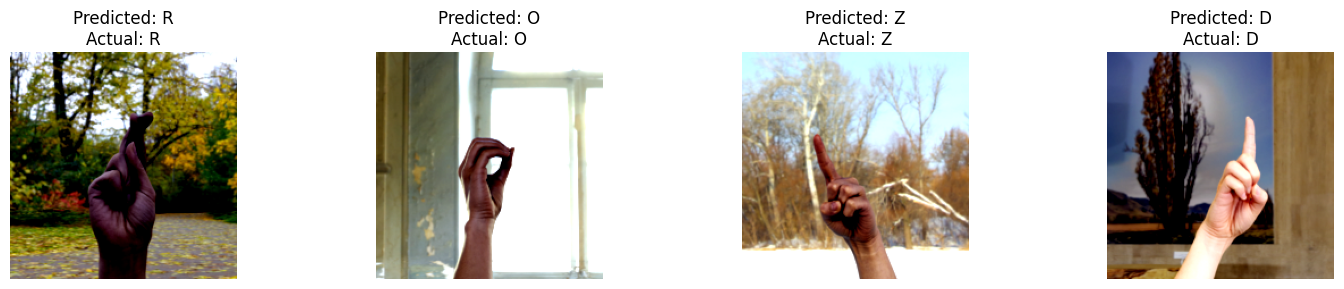

In [ ]:
show_predictions(model_path, test_loader, test.classes, num_images=4)

### CNN with DROPOUT

#### Definition 3-layer CNN with DROPUT

In [ ]:
class exampleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(exampleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 23 * 23, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 23 * 23)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate and move the model to the GPU
examplecnn_model = exampleCNN(num_classes=num_classes).to(device)

summary(examplecnn_model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Conv2d-3           [-1, 64, 97, 97]          18,496
         MaxPool2d-4           [-1, 64, 48, 48]               0
            Conv2d-5          [-1, 128, 46, 46]          73,856
         MaxPool2d-6          [-1, 128, 23, 23]               0
            Linear-7                  [-1, 512]      34,669,056
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 27]          13,851
Total params: 34,776,155
Trainable params: 34,776,155
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 20.27
Params size (MB): 132.66
Estimated Total Size (MB): 153.39
--------------------------------

#### Full Training and Validation

In [ ]:
# Define loss function and optimizer
examplecnn_criterion = nn.CrossEntropyLoss()
examplecnn_optimizer = optim.Adam(examplecnn_model.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results_cnn = training(model = examplecnn_model,
                      train_dataloader = train_loader,
                      val_dataloader = val_loader,
                      optimizer =  examplecnn_optimizer,
                      loss_fn = examplecnn_criterion,
                      epochs = 8)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.8835 - Train acc: 46.33% -  val loss: 0.5231 - val acc: 87.48%
Epoch: 1 | Train loss: 0.5101 - Train acc: 85.31% -  val loss: 0.2775 - val acc: 92.90%
Epoch: 2 | Train loss: 0.2571 - Train acc: 92.67% -  val loss: 0.1793 - val acc: 95.45%
Epoch: 3 | Train loss: 0.1488 - Train acc: 95.66% -  val loss: 0.1436 - val acc: 96.01%
Epoch: 4 | Train loss: 0.0988 - Train acc: 97.25% -  val loss: 0.1170 - val acc: 96.73%
Epoch: 5 | Train loss: 0.0714 - Train acc: 98.07% -  val loss: 0.0947 - val acc: 97.51%
Epoch: 6 | Train loss: 0.0549 - Train acc: 98.56% -  val loss: 0.0860 - val acc: 97.82%
Epoch: 7 | Train loss: 0.0399 - Train acc: 98.76% -  val loss: 0.0920 - val acc: 97.74%
Total Train Time: 2335.151 seconds


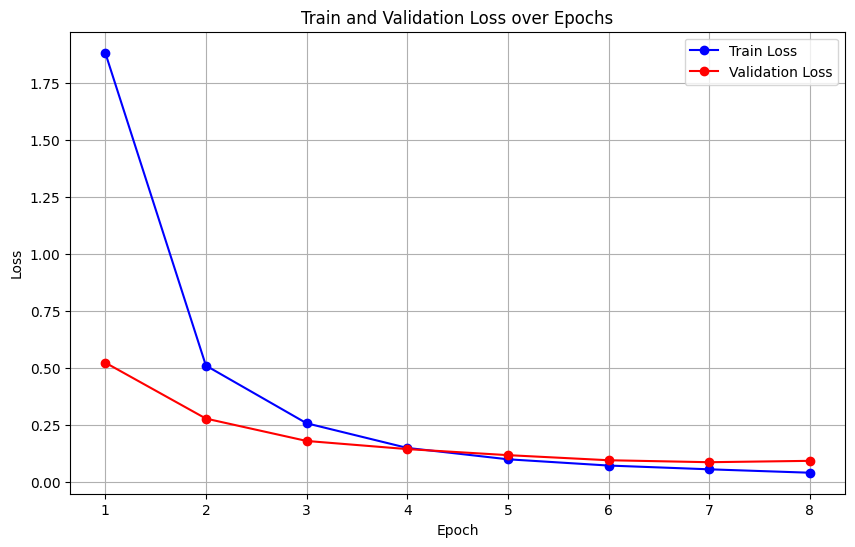

In [ ]:
plot_train_val_loss(8,  model_results_cnn ["train_loss"], model_results_cnn ["val_loss"])

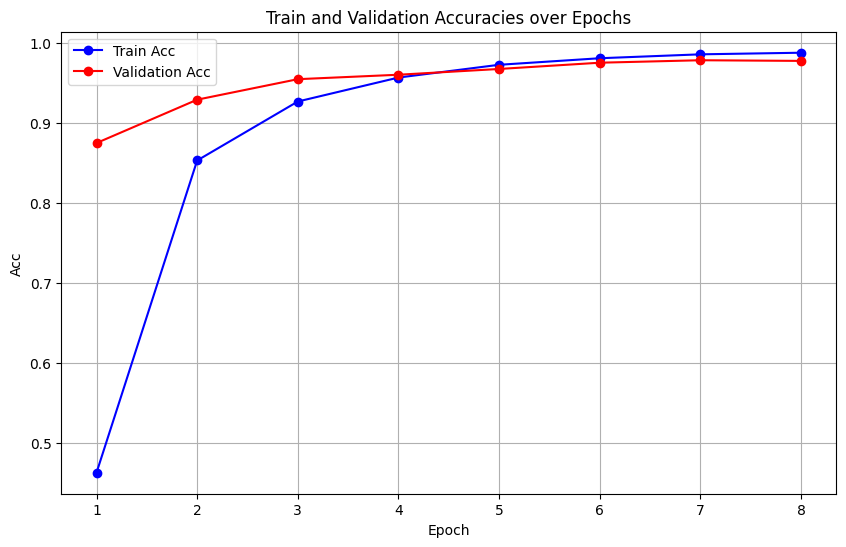

In [ ]:
plot_train_val_acc(8,  model_results_cnn ["train_acc"], model_results_cnn ["val_acc"])

In [ ]:
torch.save(examplecnn_model, 'examplecnn_model_2.pth')

#### Testing

In [ ]:
model_path='/content/examplecnn_model_2.pth'

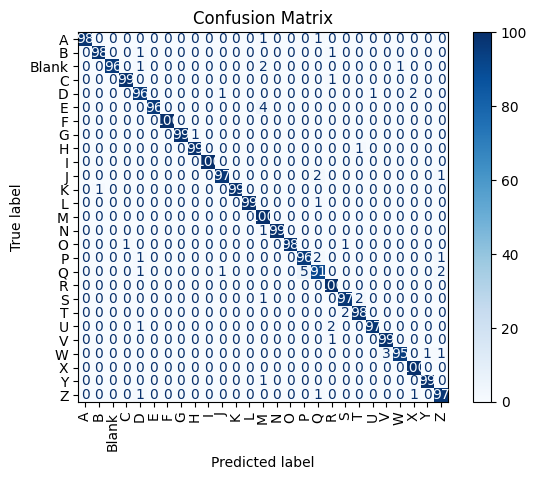

Accuracy: 97.85%


In [ ]:
accuracy = calculate_accuracy_and_confusion_matrix(test_loader, model_path, class_names)
print(f"Accuracy: {accuracy * 100:.2f}%")

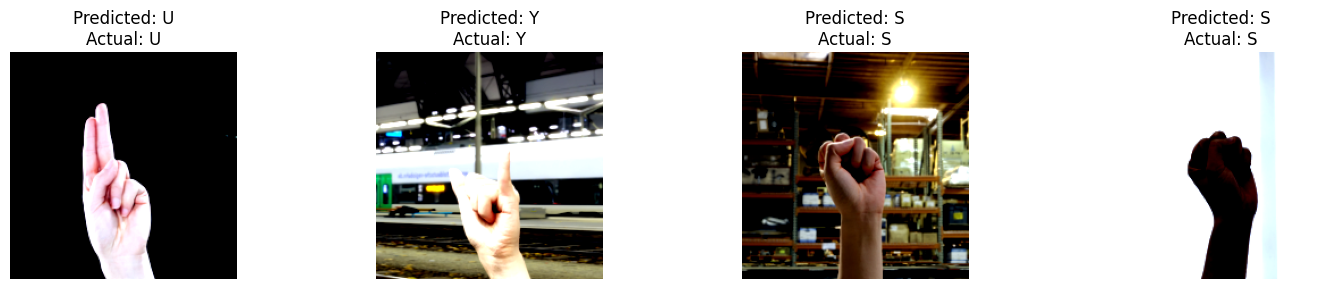

In [ ]:
show_predictions(model_path, test_loader, test.classes, num_images=4)

## Resnet50

### Data Pre-processing

In [15]:
#transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the dataset
train = datasets.ImageFolder(root='/content/dataset/train', transform=transform)
val = datasets.ImageFolder(root='/content/dataset/val', transform=transform)
test = datasets.ImageFolder(root='/content/dataset/Test_Alphabet', transform=transform)

#class names
class_names = train.classes
num_classes = len(class_names)
print(class_names)


# Creating DataLoaders
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


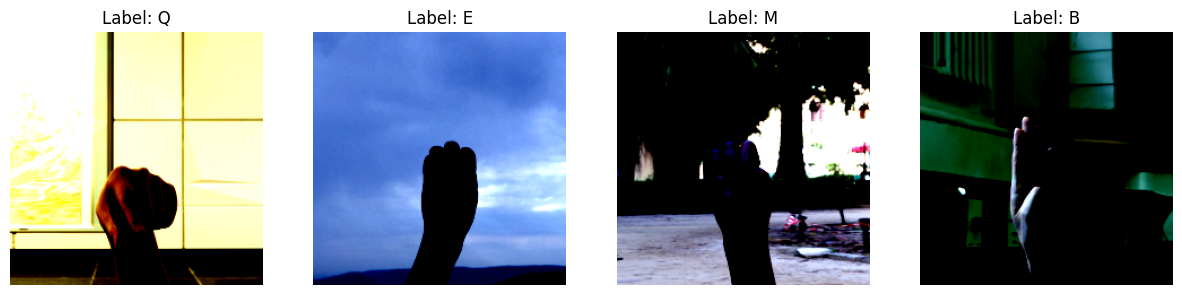

In [18]:
num_images_to_plot = 4
# Batch of images extracted
data_iter = iter(train_loader)
images, labels = next(data_iter)

#subplot
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

# loop to plot a fixed number of images and their labels
for i in range(num_images_to_plot):
    ax = axes[i]
    image = np.transpose(images[i].numpy(), (1, 2, 0))
    label = labels[i].item()
    ax.imshow(image)
    ax.set_title(f'Label: {class_names[label]}')
    ax.axis('off')

#plot
plt.show()

### Resnet50 Optimizer: Adam

#### Definition Resnet50


In [ ]:
#pre-trained Resnet model
resnet50_model = models.resnet50(pretrained=True)

# Freeze model's parameters
for param in resnet50_model.parameters():
    param.requires_grad = False

#fully connected layer modified
num_classes = len(train.classes)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)

resnet50_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(resnet50_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Transfer Learning

In [ ]:
#loss function and optimizer
resnet50_model_criterion = nn.CrossEntropyLoss()
resnet50_model_optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results_resnet = training(model = resnet50_model,
                      train_dataloader = train_loader,
                      val_dataloader = val_loader,
                      optimizer =  resnet50_model_optimizer,
                      loss_fn =resnet50_model_criterion,
                      epochs = 10)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.5876 - Train acc: 58.51% -  val loss: 0.9637 - val acc: 73.57%
Epoch: 1 | Train loss: 0.8269 - Train acc: 76.90% -  val loss: 0.7565 - val acc: 77.62%
Epoch: 2 | Train loss: 0.6683 - Train acc: 80.73% -  val loss: 0.7398 - val acc: 77.63%
Epoch: 3 | Train loss: 0.5933 - Train acc: 81.99% -  val loss: 0.6522 - val acc: 80.20%
Epoch: 4 | Train loss: 0.5283 - Train acc: 83.95% -  val loss: 0.6037 - val acc: 81.42%
Epoch: 5 | Train loss: 0.4986 - Train acc: 84.44% -  val loss: 0.5870 - val acc: 81.74%
Epoch: 6 | Train loss: 0.4571 - Train acc: 85.85% -  val loss: 0.5514 - val acc: 82.82%
Epoch: 7 | Train loss: 0.4364 - Train acc: 86.31% -  val loss: 0.5515 - val acc: 82.89%
Epoch: 8 | Train loss: 0.4083 - Train acc: 87.14% -  val loss: 0.5393 - val acc: 83.36%
Epoch: 9 | Train loss: 0.4002 - Train acc: 87.27% -  val loss: 0.5215 - val acc: 83.64%
Total Train Time: 3376.897 seconds


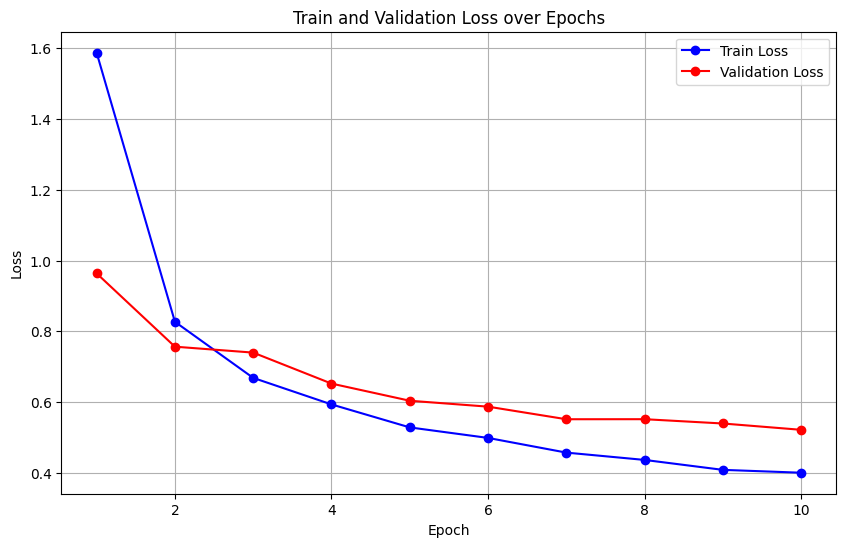

In [ ]:
plot_train_val_loss(10,  model_results_resnet ["train_loss"], model_results_resnet ["val_loss"])

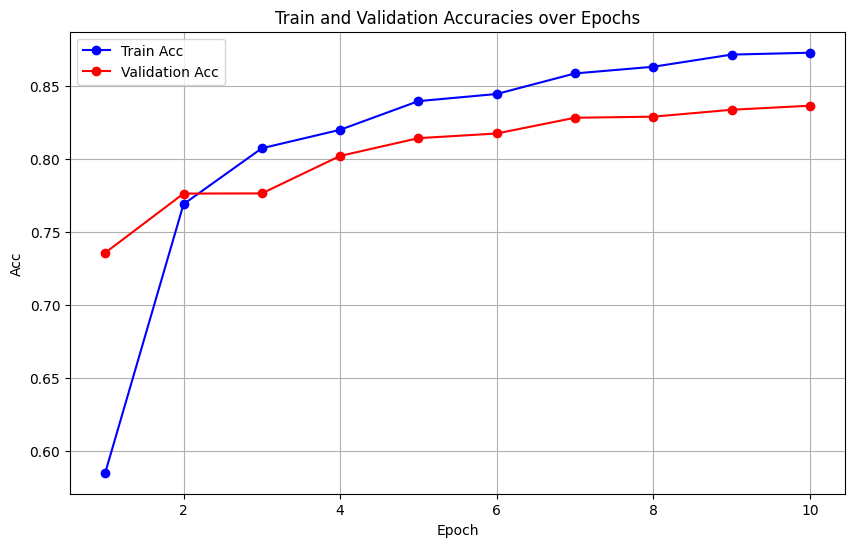

In [ ]:
plot_train_val_acc(10,  model_results_resnet ["train_acc"], model_results_resnet ["val_acc"])

In [ ]:
torch.save(resnet50_model, 'ASL_resnet50_model_1.pth')

#### Testing

In [ ]:
model_path='/content/ASL_resnet50_model_1.pth'

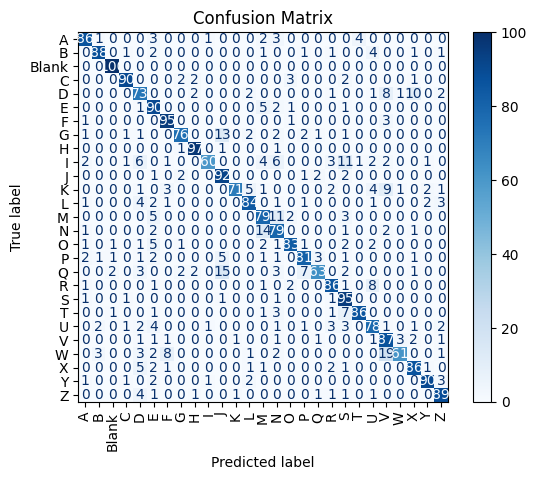

Accuracy: 83.15%


In [ ]:
accuracy = calculate_accuracy_and_confusion_matrix(test_loader, model_path, class_names)
print(f"Accuracy: {accuracy * 100:.2f}%")

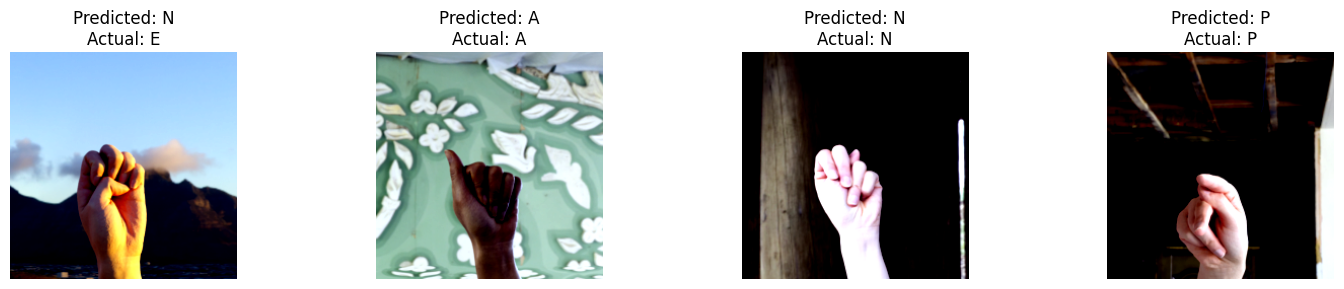

In [ ]:
show_predictions(model_path, test_loader, test.classes, num_images=4)

### Resnet50 Optimizer: SGD

#### Definition Resnet50

In [19]:
#pre-trained Resnet model
resnet50_model = models.resnet50(pretrained=True)

# Congela i parametri del modello
for param in resnet50_model.parameters():
    param.requires_grad = False

# Modifica l'ultimo livello fully connected per adattarlo al numero di classi
num_classes = len(train.classes)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)

# Sposta il modello sul dispositivo (GPU se disponibile)
resnet50_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
summary(resnet50_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Transfer Learning

In [21]:
#loss function and optimizer
resnet50_model_criterion = nn.CrossEntropyLoss()
resnet50_model_optimizer = torch.optim.SGD(params=resnet50_model.parameters(), lr=0.001, momentum=0.9)



# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results_resnet = training(model = resnet50_model,
                      train_dataloader = train_loader,
                      val_dataloader = val_loader,
                      optimizer =  resnet50_model_optimizer,
                      loss_fn =resnet50_model_criterion,
                      epochs = 10)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.4883 - Train acc: 43.73% -  val loss: 1.8340 - val acc: 64.69%
Epoch: 1 | Train loss: 1.5762 - Train acc: 68.61% -  val loss: 1.3294 - val acc: 72.57%
Epoch: 2 | Train loss: 1.2443 - Train acc: 73.74% -  val loss: 1.1187 - val acc: 74.17%
Epoch: 3 | Train loss: 1.0654 - Train acc: 76.81% -  val loss: 1.0160 - val acc: 75.67%
Epoch: 4 | Train loss: 0.9519 - Train acc: 78.71% -  val loss: 0.9136 - val acc: 78.11%
Epoch: 5 | Train loss: 0.8734 - Train acc: 79.98% -  val loss: 0.8543 - val acc: 78.78%
Epoch: 6 | Train loss: 0.8113 - Train acc: 80.76% -  val loss: 0.8214 - val acc: 78.93%
Epoch: 7 | Train loss: 0.7724 - Train acc: 81.19% -  val loss: 0.7608 - val acc: 80.49%
Epoch: 8 | Train loss: 0.7370 - Train acc: 81.93% -  val loss: 0.7458 - val acc: 80.76%
Epoch: 9 | Train loss: 0.7028 - Train acc: 82.60% -  val loss: 0.7221 - val acc: 81.22%
Total Train Time: 3423.307 seconds


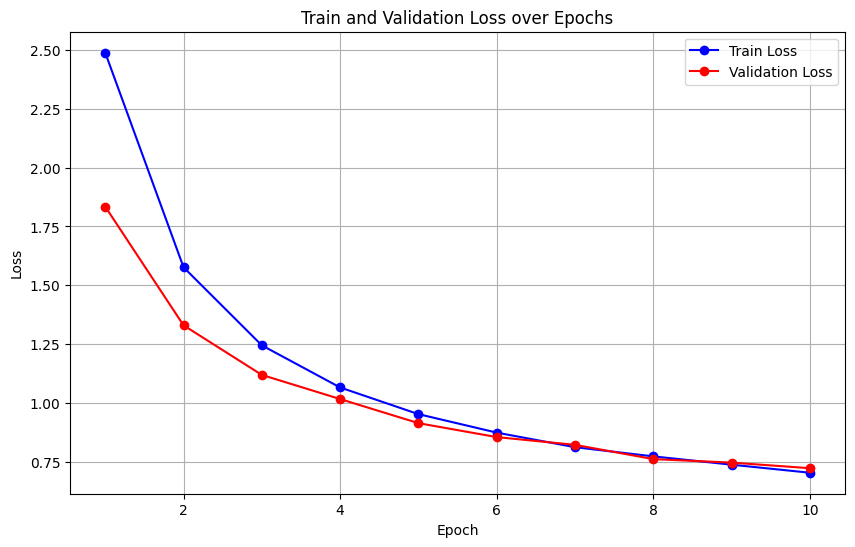

In [22]:
plot_train_val_loss(10,  model_results_resnet ["train_loss"], model_results_resnet ["val_loss"])

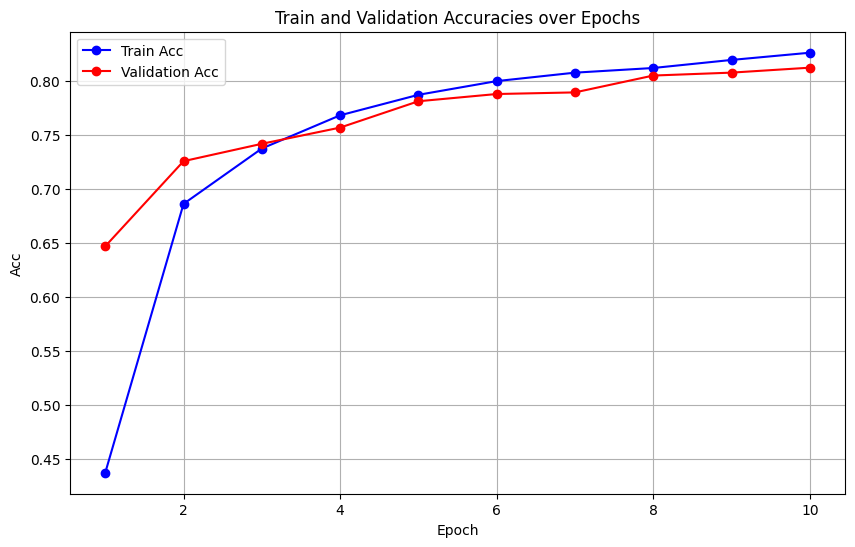

In [23]:
plot_train_val_acc(10,  model_results_resnet ["train_acc"], model_results_resnet ["val_acc"])

In [24]:
torch.save(resnet50_model, 'ASL_resnet50_model_2.pth')

#### Testing

In [25]:
model_path='/content/ASL_resnet50_model_2.pth'

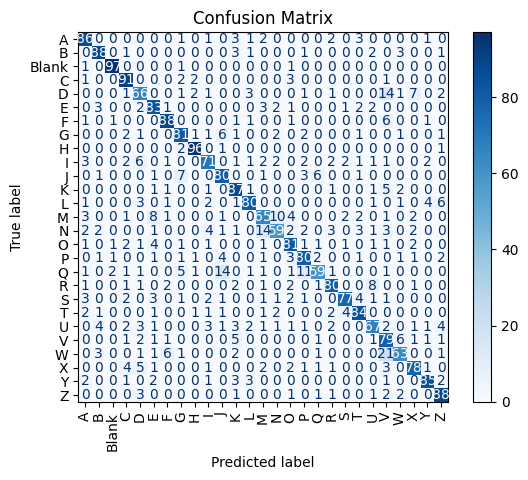

Accuracy: 79.22%


In [26]:
accuracy = calculate_accuracy_and_confusion_matrix(test_loader, model_path, class_names)
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


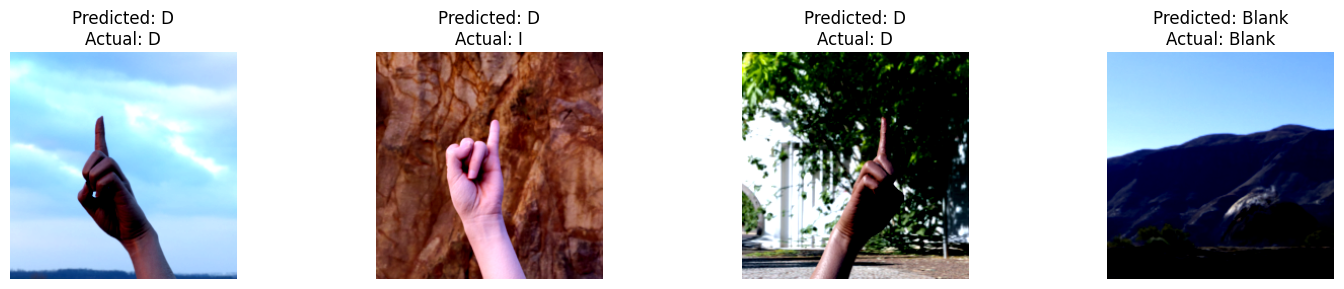

In [27]:
show_predictions(model_path, test_loader, test.classes, num_images=4)

## EfficientNetB0

### Data Pre-processing

In [ ]:
#transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Loading the dataset
train = datasets.ImageFolder(root='/content/dataset/train', transform=transform)
val = datasets.ImageFolder(root='/content/dataset/val', transform=transform)
test = datasets.ImageFolder(root='/content/dataset/Test_Alphabet', transform=transform)

#class names
class_names = train.classes
num_classes = len(class_names)



# Creating DataLoaders
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

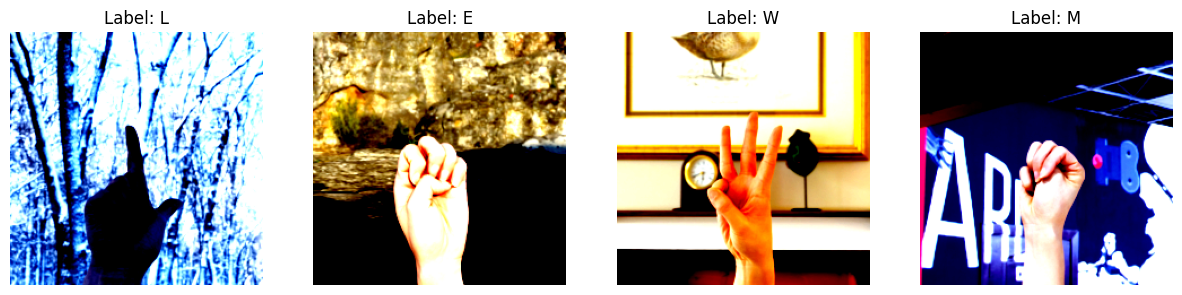

In [ ]:
num_images_to_plot = 4
# Batch of images extracted
data_iter = iter(train_loader)
images, labels = next(data_iter)

#subplot
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

# loop to plot a fixed number of images and their labels
for i in range(num_images_to_plot):
    ax = axes[i]
    image = np.transpose(images[i].numpy(), (1, 2, 0))
    label = labels[i].item()
    ax.imshow(image)
    ax.set_title(f'Label: {class_names[label]}')
    ax.axis('off')

#plot
plt.show()

### EfficientNetB0 Optimizer: Adam

#### Definition EfficientNetB0


In [ ]:
!pip install efficientnet_pytorch torchinfo

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary

#num_classes = len(class_names)    # Number of classes
num_classes=27


# Instantiate the EfficientNet model
model_efficientnetb0 = EfficientNet.from_pretrained('efficientnet-b0').to(device)
# Freeze parameters
for param in model_efficientnetb0.parameters():
    param.requires_grad = False

model_efficientnetb0._fc = nn.Linear(model_efficientnetb0._fc.in_features, num_classes)



Loaded pretrained weights for efficientnet-b0


#### Transfer Learning


In [ ]:
# Setup loss functions and optimizer
loss_fn_effnetb0 = nn.CrossEntropyLoss()
optimizer_effnetb0 = torch.optim.Adam(params = model_efficientnetb0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

model_efficientnetb0 = model_efficientnetb0.to(device)


# Train model
model_results_effnetb0 = training(model =model_efficientnetb0,
                      train_dataloader = train_loader,
                      val_dataloader = val_loader,
                      optimizer = optimizer_effnetb0,
                      loss_fn = loss_fn_effnetb0,
                      epochs = 10)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.5300 - Train acc: 69.08% -  val loss: 0.7434 - val acc: 85.86%
Epoch: 1 | Train loss: 0.7465 - Train acc: 83.19% -  val loss: 0.5243 - val acc: 88.46%
Epoch: 2 | Train loss: 0.5862 - Train acc: 85.61% -  val loss: 0.4364 - val acc: 89.40%
Epoch: 3 | Train loss: 0.5043 - Train acc: 86.91% -  val loss: 0.3802 - val acc: 89.92%
Epoch: 4 | Train loss: 0.4544 - Train acc: 87.85% -  val loss: 0.3488 - val acc: 90.90%
Epoch: 5 | Train loss: 0.4110 - Train acc: 89.08% -  val loss: 0.3280 - val acc: 90.99%
Epoch: 6 | Train loss: 0.3862 - Train acc: 89.32% -  val loss: 0.3077 - val acc: 91.18%
Epoch: 7 | Train loss: 0.3691 - Train acc: 89.53% -  val loss: 0.2948 - val acc: 91.15%
Epoch: 8 | Train loss: 0.3544 - Train acc: 89.54% -  val loss: 0.2866 - val acc: 91.63%
Epoch: 9 | Train loss: 0.3459 - Train acc: 89.87% -  val loss: 0.2805 - val acc: 91.50%
Total Train Time: 3275.284 seconds


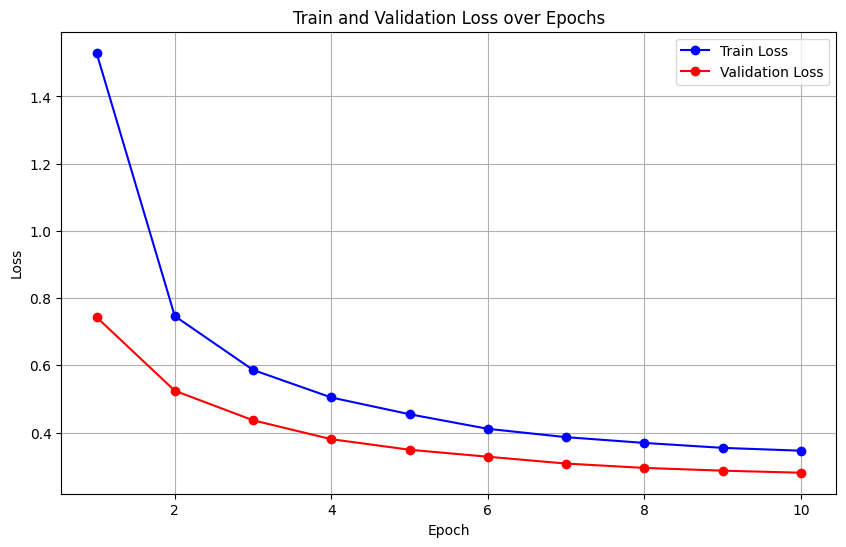

In [ ]:
plot_train_val_loss(10,  model_results_effnetb0 ["train_loss"], model_results_effnetb0 ["val_loss"])

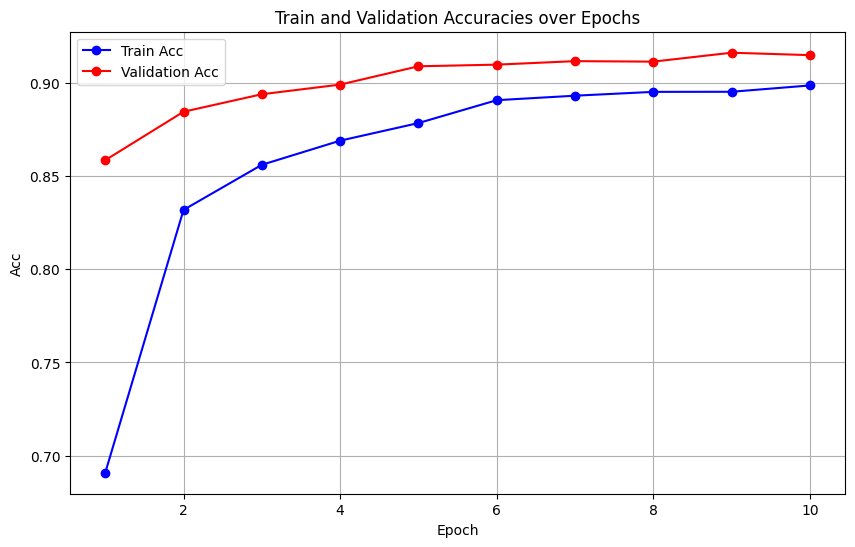

In [ ]:
plot_train_val_acc(10,  model_results_effnetb0 ["train_acc"], model_results_effnetb0 ["val_acc"])

In [ ]:
torch.save(model_efficientnetb0, 'ASL_model_results_effnetb0_1.pth')

#### Testing

In [ ]:
model_path='ASL_model_results_effnetb0_1.pth'

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


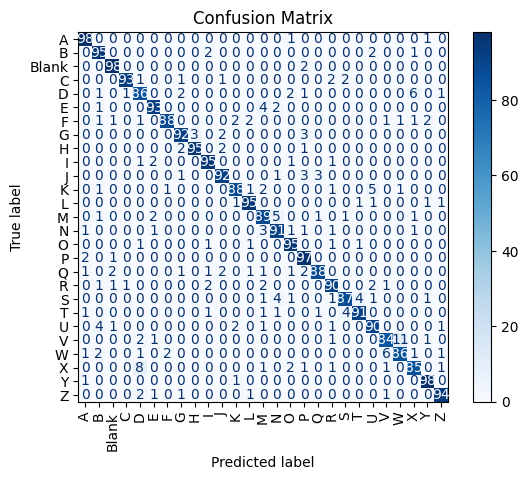

------------------------------------------
Accuracy: 91.59%


In [ ]:
accuracy = calculate_accuracy_and_confusion_matrix(test_loader, model_path, class_names)
print("------------------------------------------")
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


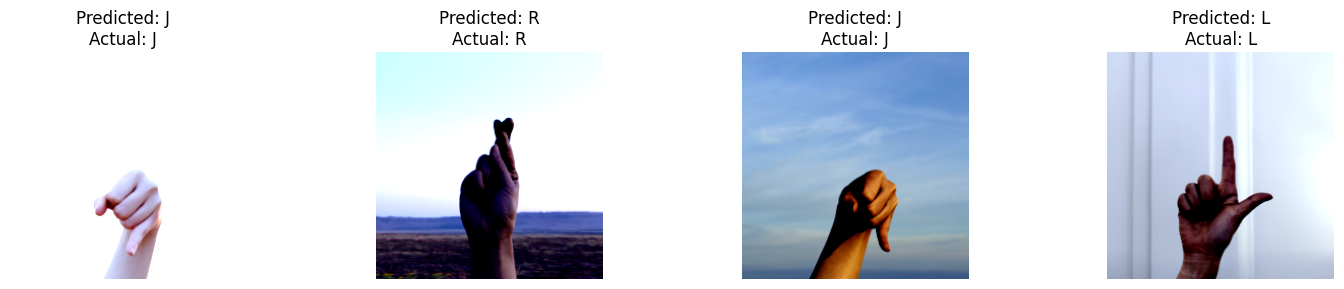

In [ ]:
show_predictions(model_path, test_loader, test.classes, num_images=4)

non va bene che model sia quello di effnet ma ci vuole una variabile specifica

### EfficientNetB0 Optimizer: SGD

#### Definition EfficientNetB0

In [ ]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary

#num_classes = len(class_names)    # Number of classes
num_classes=27


# Instantiate the EfficientNet model
model_efficientnetb0 = EfficientNet.from_pretrained('efficientnet-b0').to(device)
# Freeze parameters
for param in model_efficientnetb0.parameters():
    param.requires_grad = False

model_efficientnetb0._fc = nn.Linear(model_efficientnetb0._fc.in_features, num_classes)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 278MB/s]


Loaded pretrained weights for efficientnet-b0


#### Transfer Learning

In [ ]:
# Setup loss functions and optimizer
loss_fn_effnetb0 = nn.CrossEntropyLoss()
optimizer_effnetb0 = torch.optim.SGD(params=model_efficientnetb0.parameters(), lr=0.001, momentum=0.9)



# Start the timer
from timeit import default_timer as timer
start_time = timer()

model_efficientnetb0 = model_efficientnetb0.to(device)


# Train model
model_results_effnetb0 = training(model =model_efficientnetb0,
                      train_dataloader = train_loader,
                      val_dataloader = val_loader,
                      optimizer = optimizer_effnetb0,
                      loss_fn = loss_fn_effnetb0,
                      epochs = 10)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.8414 - Train acc: 40.18% -  val loss: 2.3232 - val acc: 69.76%
Epoch: 1 | Train loss: 2.1381 - Train acc: 68.62% -  val loss: 1.7614 - val acc: 78.00%
Epoch: 2 | Train loss: 1.7265 - Train acc: 74.90% -  val loss: 1.4340 - val acc: 80.73%
Epoch: 3 | Train loss: 1.4694 - Train acc: 77.14% -  val loss: 1.2262 - val acc: 82.77%
Epoch: 4 | Train loss: 1.2962 - Train acc: 78.77% -  val loss: 1.0823 - val acc: 84.11%
Epoch: 5 | Train loss: 1.1689 - Train acc: 80.26% -  val loss: 0.9787 - val acc: 84.94%
Epoch: 6 | Train loss: 1.0814 - Train acc: 80.90% -  val loss: 0.9017 - val acc: 85.58%
Epoch: 7 | Train loss: 1.0149 - Train acc: 81.68% -  val loss: 0.8443 - val acc: 85.82%
Epoch: 8 | Train loss: 0.9543 - Train acc: 81.79% -  val loss: 0.7923 - val acc: 86.61%
Epoch: 9 | Train loss: 0.9098 - Train acc: 82.61% -  val loss: 0.7523 - val acc: 86.99%
Total Train Time: 3176.252 seconds


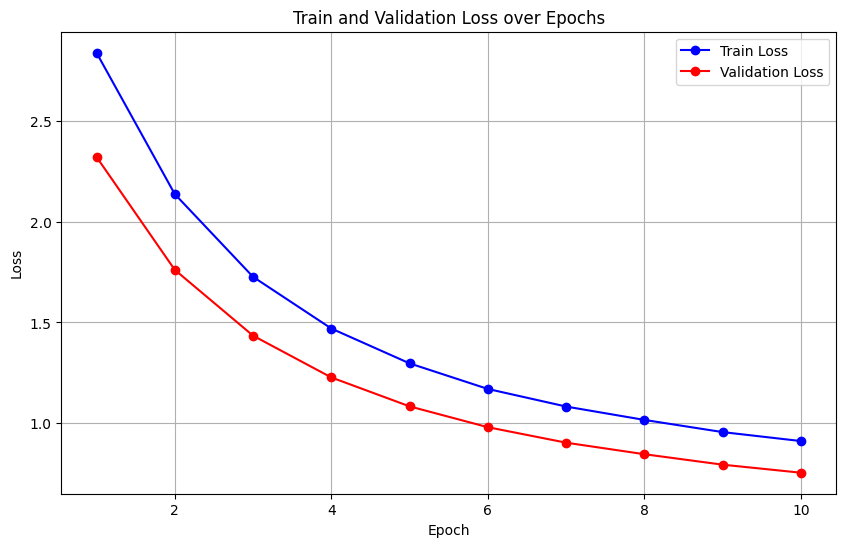

In [ ]:
plot_train_val_loss(10,  model_results_effnetb0 ["train_loss"], model_results_effnetb0 ["val_loss"])

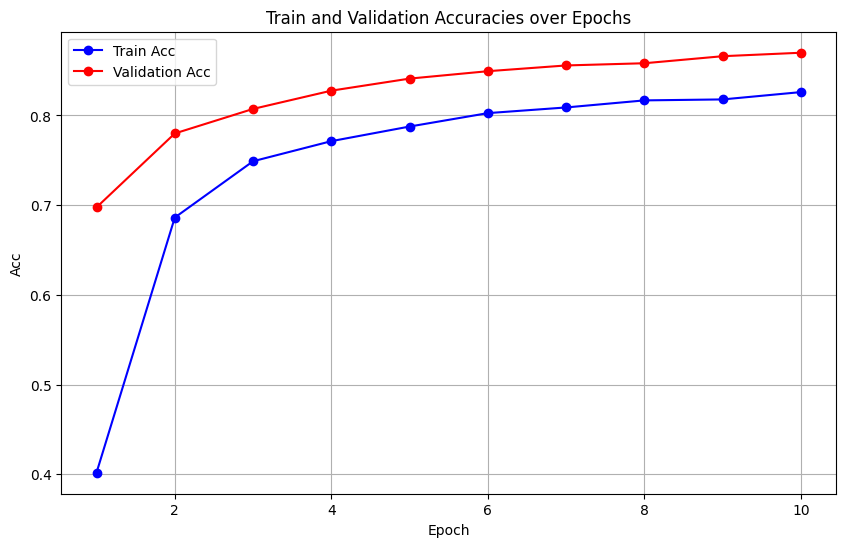

In [ ]:
plot_train_val_acc(10,  model_results_effnetb0 ["train_acc"], model_results_effnetb0 ["val_acc"])

In [ ]:
torch.save(model_efficientnetb0, 'ASL_model_results_effnetb0_2.pth')

#### Testing

In [ ]:
model_path='ASL_model_results_effnetb0_2.pth'

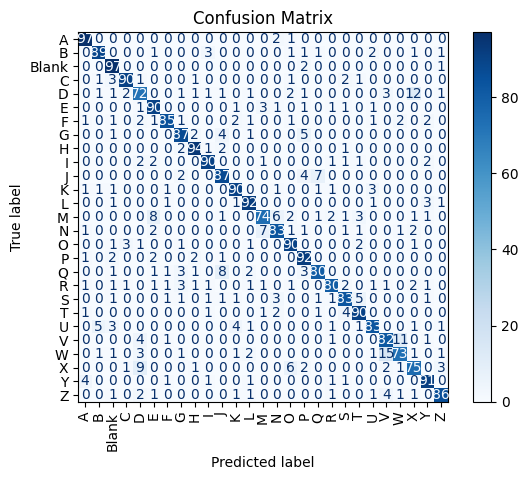

Accuracy: 86.00%


In [ ]:
accuracy = calculate_accuracy_and_confusion_matrix(test_loader, model_path, class_names)
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


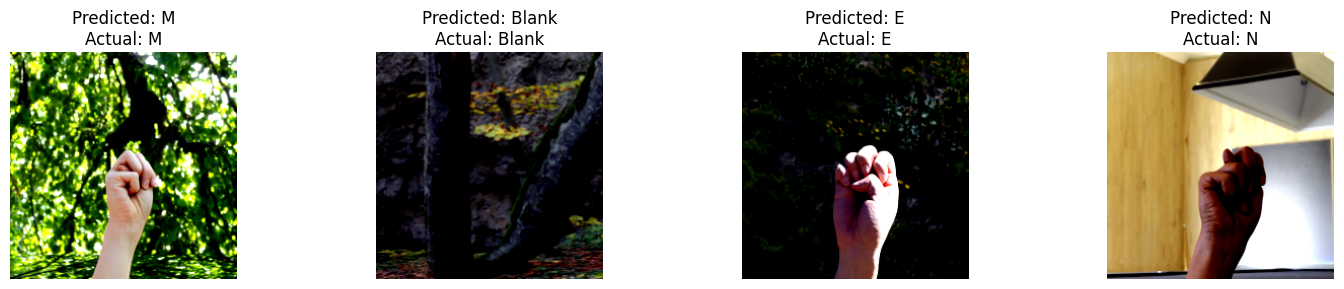

In [ ]:
show_predictions(model_path, test_loader, test.classes, num_images=4)